In [57]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numba
from numba.experimental import jitclass
BETA = 1

element_spec = [('x0', numba.float32), ('y0', numba.float32),
                ('x1', numba.float32), ('y1', numba.float32),
                ('w', numba.float32), ('h', numba.float32),
                ('area', numba.float32), ('_centre', numba.float32[:]),
                ('I', numba.float32)]


@jitclass(element_spec)
class Element:
    def __init__(self, x, y, width, height):
        self.x0 = x
        self.y0 = y
        self.x1 = x + width
        self.y1 = y + height

        self.w = width
        self.h = height

        self.area = self.w * self.h

        self.I = 1.0
        self._centre = np.asarray([(self.x1 + self.x0) / 2,
                                   (self.y1 + self.y0) / 2],
                                  dtype=np.float32)

    def get_contribution_at_p(self, p) -> float:
        dist = np.sqrt(
            np.sum(np.asarray([(p[i] - self._centre[i])**2 for i in [0, 1]])))
        return BETA * self.I / dist

    def get_vector_contribution_at_p(self, p) -> np.ndarray:
        diff_vector = p - self._centre
        perp_vector = np.cross(diff_vector, np.array([0., 0., 1.]))
        dist = np.sqrt(np.sum(np.power(diff_vector, 2)))
        mag = BETA * self.I / dist
        return mag * perp_vector / np.linalg.norm(perp_vector)

    def set_current(self, I):
        self.I = I

    def get_sides(self):
        return [
            # FRONT FACE
            [(self.x0, self.y0), (self.x1, self.y0), (self.x1, self.y1),
             (self.x0, self.y1)],

            # BACK FACE
            [(self.x0, self.y0), (self.x1, self.y0), (self.x1, self.y1),
             (self.x0, self.y1)],

            # LEFT FACE
            [(self.x0, self.y0), (self.x0, self.y0), (self.x0, self.y1),
             (self.x0, self.y1)],

            # RIGHT FACE
            [(self.x1, self.y0), (self.x1, self.y0), (self.x1, self.y1),
             (self.x1, self.y1)],

            # TOP FACE
            [(self.x0, self.y1), (self.x1, self.y1), (self.x1, self.y1),
             (self.x0, self.y1)],

            # BOTTOM FACE
            [(self.x0, self.y0), (self.x1, self.y0), (self.x1, self.y0),
             (self.x0, self.y0)],
        ]


class CompositeStructure:
    def __init__(self, composites, power=10):
        self.composites = composites
        # calculate the total resistance
        R_tot = sum([composite.resistance for composite in composites])
        I_tot = np.sqrt(power / R_tot)
        print(R_tot, I_tot)
        for i, composite in enumerate(composites):
            rel_I = I_tot * R_tot / composite.resistance
            print(rel_I)
            composite.set_per_element_current(rel_I)

    @staticmethod
    #     @numba.jit(nopython=False, parallel=False)
    def calculate_contribs(composites, Xs, Ys):
        total_contribs = np.zeros_like(Xs).astype(np.float32)
        for composite in composites:
            total_contribs += Composite.calculate_contribs(
                composite.elements, Xs.ravel(), Ys.ravel()).reshape(Xs.shape)
        return total_contribs


class Composite:
    def __init__(self, size, discretisation, offset, resistivity=1):
        """
        @param size:
            (W, L, H) aka (x, y, z)
        @param discretisation:
            sizes of tiny element
        """
        (self.w, self.h, self.l) = size
        self.area = self.w * self.h
        self.elements = mesh_discretisation(self.w,
                                            self.h,
                                            *discretisation,
                                            offset=offset)
        self.resistance = self.get_resistance(resistivity, self.l)
        self.offset = offset
        (self.Nx, self.Ny) = discretisation

    def set_current(self, I):
        element: Element
        for element in self.elements:
            element.set_current(I)

    def get_sides(self):
        all_sides = []
        for el in self.elements:
            yield el.get_sides()

    @staticmethod
    @numba.jit(nopython=True, parallel=False)
    def calculate_contribs(elements, Xs, Ys):
        vals = []
        for xp, yp in zip(Xs, Ys):
            p = (xp, yp)
            points_contributions = 0.0
            el: Element
            for el in elements:
                points_contributions += el.get_contribution_at_p(p)
            vals.append(points_contributions)
        return np.asarray(vals)

    @staticmethod
    @numba.jit(nopython=True, parallel=False)
    def calculate_vector_contribs(elements, Xs, Ys):
        vals = np.zeros((*Xs.shape, 2), dtype=np.float32)
        for i in range(Xs.shape[0]):
            for j in range(Xs.shape[1]):
                for el in elements:
                    vals[i, j, :] += el.get_vector_contribution_at_p(
                        np.asarray([Xs[i, j], Ys[i, j]]))
        return vals

    def get_resistance(self, resistivity, length):
        # assume all elements are of the same size
        return material_resistance(resistivity, self.area, self.l)

    def set_per_element_current(self, current):
        # the current is evenly distributed along the cross-sec.
        per_element_current = current / self.Nx * self.Ny
        self.set_current(per_element_current)
        return per_element_current


def mesh_discretisation(swidth, sheight, rwidth, rheight,
                        offset=(0, 0, 0)) -> List[Element]:
    """
    @param offset 
        top left corner (for the first block, it's usually (0,0,0) 
        i.e. origin point)
    Length => Y
    Height => Z
    Width => X
    """
    Nx, Ny = int(swidth / rwidth), int(sheight / rheight)
    (xoff, yoff) = offset
    #     print(f"Nx {Nx} Ny {Ny}")
    element_groups: List[Element] = []
    for ix in range(Nx):
        for iy in range(Ny):
            el = Element(xoff + ix * rwidth, yoff + iy * rheight, rwidth,
                         rheight)
            element_groups.append(el)

    return element_groups


def material_resistance(resistivity, area, length):
    return resistivity * length / area

6.24e-08
1.06e-07
6.24e-08
1.4425e-08 26329.468304794376
97385.27699914329
57328.691365533414
97385.27699914329


<ipython-input-59-991d19cceed1>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  t = ax.pcolor(X[::2, ::2], Y[::2, ::2], CC[::2, ::2])


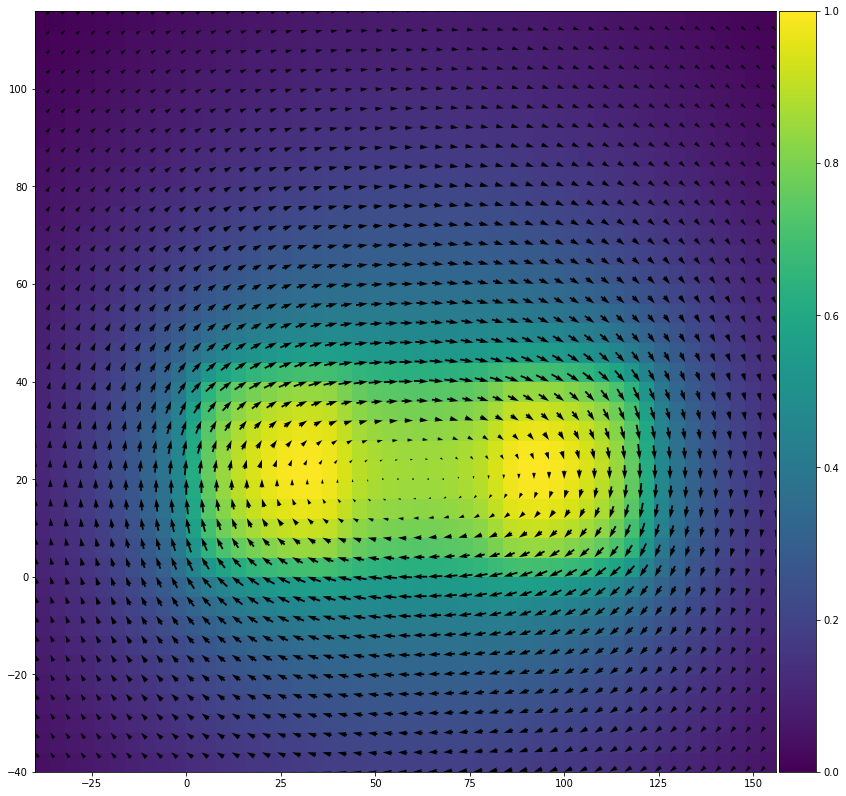

In [59]:
# x, y, z

sizeW = 40
sizeL = 100
sizeH = 40

max_grid = max(sizeW, sizeL, sizeH)

structure = [
    ("Co", 62.4e-9),
    ("Pt", 10.6e-8),
    ("Co", 62.4e-9),
]
N = 3

x = np.arange(-sizeW, N * sizeW + sizeW, 2)
y = np.arange(-sizeH, N * sizeH, 2)

X, Y = np.meshgrid(x, y)
org_s = X.shape

composites = []
CC = np.zeros_like(X).astype(float)
VC = np.zeros((*X.shape, 2), dtype=np.float32)
for i, (k, r) in enumerate(structure):
    print(r)
    composite = Composite(size=(sizeW, sizeH, sizeL),
                          discretisation=(2, 2),
                          offset=(i * sizeW, 0),
                          resistivity=r)
    VC += Composite.calculate_vector_contribs(composite.elements, X, Y)
    #     composite.set_current(1)
    composites.append(composite)
#     CC += Composite.calculate_contribs(composite.elements, X.ravel(),
#                                        Y.ravel()).reshape(X.shape)
struct = CompositeStructure(composites)
CC = CompositeStructure.calculate_contribs(struct.composites, X.ravel(),
                                           Y.ravel()).reshape(X.shape)

fig, ax = plt.subplots(figsize=(14, 14))
t = ax.pcolor(X[::2, ::2], Y[::2, ::2], CC[::2, ::2])

im = ax.quiver(X[::2, ::2],
               Y[::2, ::2],
               VC[::2, ::2, 0],
               VC[::2, ::2, 1],
               units='width',
               pivot='tip')
ax.scatter(X, Y, color='r', s=0.5, alpha=0.6)
ax.set_xlabel("X")
ax.set_ylabel("Y")
# ax.set_xticks(np.arange(len(x)))
ax.tick_params(axis='x', rotation=90)
# ax.set_yticks(np.arange(len(y)))
ax.set_xticklabels(x)
ax.set_yticklabels(y)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=cax, orientation='vertical')